## Table of Contents

- [Introduction](#intro)
- [Import Libraries and Helper Functions](#lib)
- [Data Analysis](#analysis)
- [Data Modelling](#model)
- [Conclusion](#conclusion)

### <a id = "intro">Introduction</a>

Ship detection and recognition has been widely used in many different areas. For example, identifying ship type and sizes before entering a seaport for mairitime safety and security, and efficient port management. Mangaging the impact of maritime activities in the waters involves tasks such as identifying oil tankers, as oil spillage can lead to catastrophic consequences in the sea.

Image recognition may prove to be challenging when dealing with a diverse range of ship types, varying weather conditions which may complicate the image backgrounds, or variations in camera specifications such as white balance, lens focus and focal length.

#### Dataset
There are a total of 8932 train and test data images in the dataset. However, we will only be using the train set as the whole dataset (6252 images) as only the train set are labelled.

The csv dataset contains the following features
1) image: Image file name
2) category: Ship class/category index

The 5 different ship classes (and their category index) are:
- Cargo (1)
- Military (2)
- Carrier (3)
- Cruise (4)
- Tankers (5)

The image files contains all ship images in jpg format.

#### Objective

The objective is to design a Convolutional Neural Network (CNN) model that can distinguish and classify ships from the images. It has to be a robust model that can handle real-world challenges, including variations such as different ship size, ship orientations and current environment conditions.

Note: This notebook is created using Google Colab, as such, hardware resources such as CPU/GPU Memory may be limited.

### <a id = "lib">Import Libraries and Helper Functions</a>

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from tqdm import tqdm

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix

tqdm.pandas()

In [ ]:
%cd drive/MyDrive/Colab Notebooks/IBM/Deep Learning and Reinforcement Learning/Week 9/Final Project

train_csv_filename = "train/train.csv"
image_folder = "train/images"

/content/drive/MyDrive/Colab Notebooks/IBM/Deep Learning and Reinforcement Learning/Week 9/Final Project


In [ ]:
# This function displays the total count of ships per category
def DisplayCatDistribution(cat_count_df, title = ""):
  colours = ['skyblue', 'salmon', 'lightgreen', 'gold', 'orchid']

  fig, axList = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
  fig.suptitle(f"Distribution of Images {title}")

  axList[0].bar(cat_count_df.index, cat_count_df.values, color = colours)
  axList[0].set_ylabel("Count", rotation = 0, labelpad = 30)

  for bar in axList[0].patches:
    axList[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), bar.get_height(), ha = "center", va = "bottom")

  axList[1].pie(cat_count_df.values, labels = cat_count_df.index, autopct = "%1.1f%%", startangle = 90, colors = colours)

  plt.show()

In [ ]:
# This function loads images from the image folder to a numpy object. The image dimension is set to 224x224 pixels
def load_images(df, img_dim = (224, 224)):
  arr = []

  for file in tqdm(df["image"].values):
    img = load_img(os.path.join(image_folder, file), target_size = img_dim)
    img = img_to_array(img) / 255.

    arr.append(img)

  return np.array(arr)

In [ ]:
# This function displays images from a numpy object
def DisplayImages(img_arr, df_for_label = None):
  fig, axList = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 4))

  axList = axList.flatten()

  for i, axs in enumerate(axList):
    axs.imshow(img_arr[i])
    axs.axis("off")

    if df_for_label is not None:
      axs.set_title(f"{df_for_label.loc[i, 'category']}")

  plt.show()

### <a id = "analysis">Data Analysis</a>

In [ ]:
image_filenames = []
for filename in Path(image_folder).iterdir():
  filename = str(filename)
  image_filenames.append(filename.split("/")[2])

In [ ]:
df = pd.read_csv(train_csv_filename)

In [ ]:
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
image_filenames[0], len(image_filenames)

('2891600.jpg', 8932)

In [ ]:
image_filenames = [image_name for image_name in df["image"].to_list() if image_name in image_filenames]

In [ ]:
image_filenames[0], len(image_filenames)

('2823080.jpg', 6252)

In [ ]:
df["category"] = df["category"].replace({1: "Cargo", 2: "Military", 3: "Carrier", 4: "Cruise", 5: "Tankers"})

In [ ]:
cat_count_df = df["category"].value_counts().sort_index()

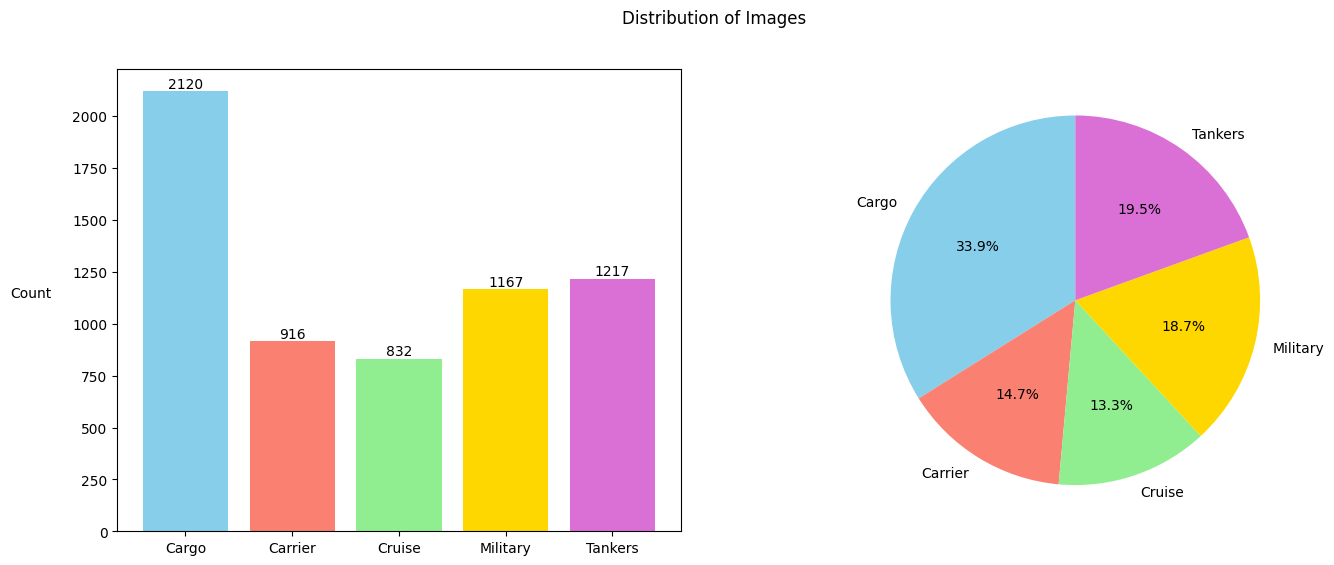

In [ ]:
DisplayCatDistribution(cat_count_df)

- We can see that the dataset is imbalanced, there are almost twice as many in Cargo than in other ship categories.
- To tackle this issue, we will downsize our training set to be balanced. In this lab, we will downsize all categories to 500 images at random.
- The rest of the images, will be used as our testing set

In [ ]:
cat_sample_size = 500

train_df = []

for category in df["category"].unique():
  train_df.append(df.loc[df["category"] == category].sample(n = cat_sample_size, random_state = 42))

train_df = pd.concat(train_df).sample(frac = 1., random_state = 42).reset_index(drop = True)

In [ ]:
train_df

,image,category
0,2863013.jpg,Carrier
1,2902009.jpg,Carrier
2,2894745.jpg,Carrier
3,2890389.jpg,Tankers
4,1387869.jpg,Cruise
...,...,...
2495,2638485.jpg,Cruise
2496,2908292.jpg,Carrier
2497,2890618.jpg,Carrier
2498,2863827.jpg,Carrier


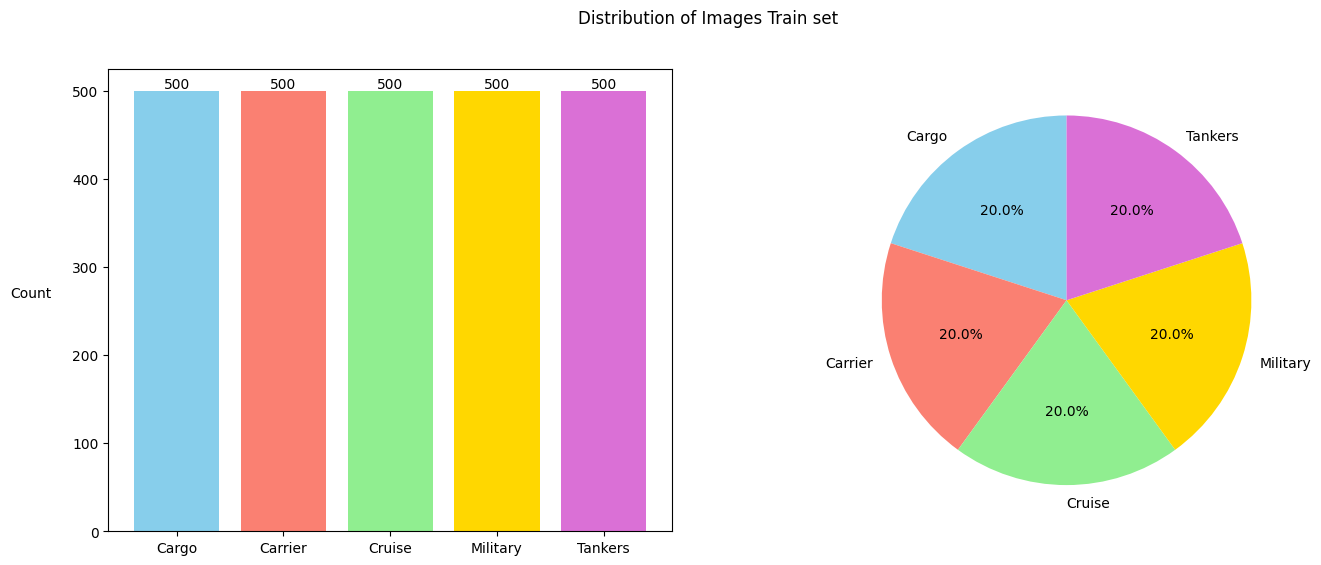

In [ ]:
cat_count_train_df = train_df["category"].value_counts().sort_index()
DisplayCatDistribution(cat_count_train_df, title = "Train set")

In [ ]:
test_df = df.merge(train_df, how = "left", indicator = True)
test_df = test_df.loc[test_df["_merge"] == "left_only", ["image", "category"]].reset_index(drop = True)
test_df

,image,category
0,2823080.jpg,Cargo
1,2870024.jpg,Cargo
2,2662125.jpg,Military
3,2804883.jpg,Military
4,2833467.jpg,Cargo
...,...,...
3747,2883073.jpg,Carrier
3748,1145083.jpg,Military
3749,2898652.jpg,Tankers
3750,2868175.jpg,Carrier


In [ ]:
# Check for merging error

# train data and test data should add up to all data
assert(train_df.shape[0] + test_df.shape[0] == df.shape[0])

# there should be no duplicates
assert(pd.merge(train_df, test_df, how = "inner").empty)

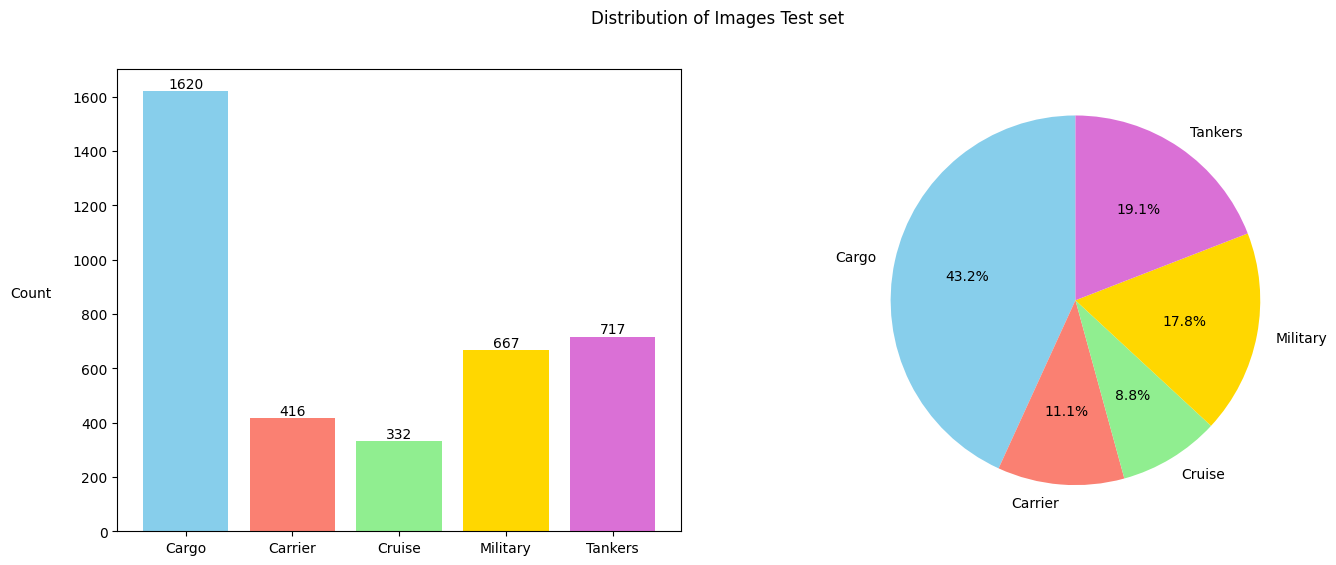

In [ ]:
cat_count_test_df = test_df["category"].value_counts().sort_index()
DisplayCatDistribution(cat_count_test_df, title = "Test set")

We have:
- Training set
    - 500 images per category (500 * 5 = 2500 images in total)
- Testing set
    - Remaining images (3752 images in total)
 
Now we can proceed to retrieve the images from the image folder. They will be in either the training or testing set based on the split.

In [ ]:
x_train = load_images(train_df)
x_test = load_images(test_df)

100%|██████████| 3752/3752 [00:13<00:00, 287.29it/s]


In [ ]:
x_train.shape, x_test.shape

((2500, 224, 224, 3), (3752, 224, 224, 3))

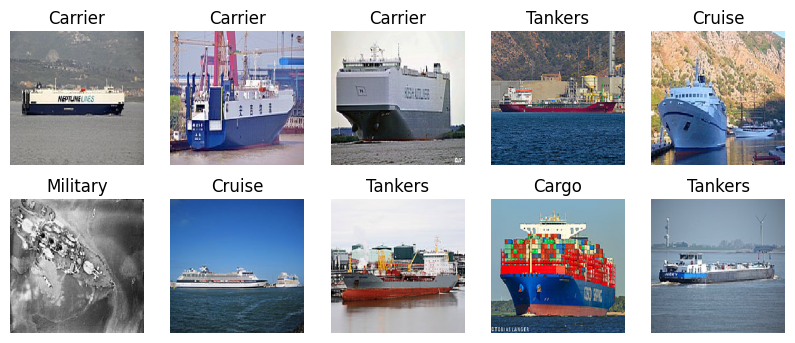

In [ ]:
DisplayImages(x_train, train_df)

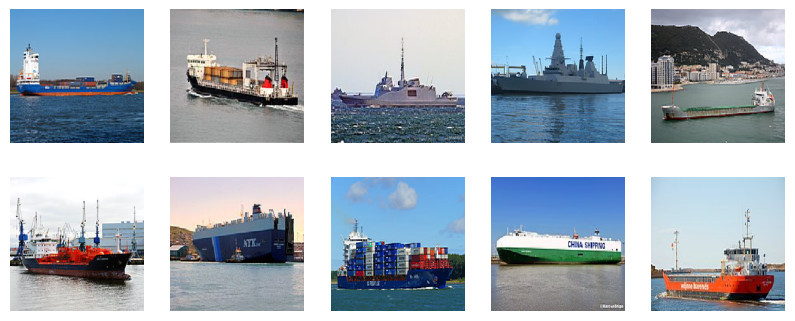

In [ ]:
DisplayImages(x_test)

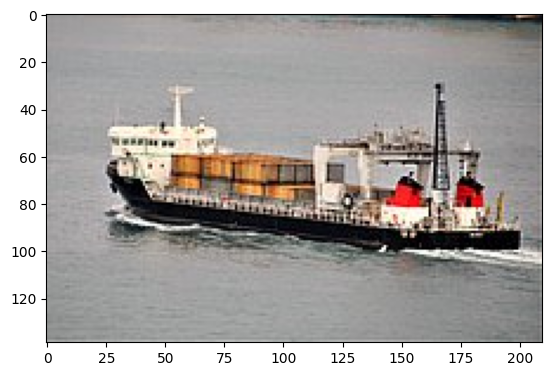

In [ ]:
test_img = load_img(os.path.join(image_folder, "2870024.jpg"))
test_img = img_to_array(test_img) / 255.

test_img = test_img.reshape((1, ) + test_img.shape)

plt.imshow(test_img[0])

- We can see that there are many different kind of images. Some are coloured, while others are grayscaled.
- Not all ships are facing the same direction (Ship Orientation), and some ships are small while others are bigger.
- Extracting features just from the original dataset may be tricky as the model may not be able to learn the many features the different images have.
- Therefore, we will have to do image augmentation, on the training set.

### <a id = "model">Data Modelling</a>

In [ ]:
encoder = OneHotEncoder(sparse_output = False)

y_train = encoder.fit_transform(np.array(train_df["category"]).reshape(-1, 1)).astype(int)
y_test = encoder.transform(np.array(test_df["category"]).reshape(-1, 1)).astype(int)

In [ ]:
encoded_features = encoder.get_feature_names_out(["category"])
encoded_features = [cat.split("_")[1] for cat in encoded_features]

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    dtype = "float32"
)

datagen.fit(x_train, rounds = 1, seed = 42)
train_gen = datagen.flow(x_train, y_train, batch_size = 32, seed = 42)

- Using ImageDataGenerator(), we can generate images by augmenting it.
- train_gen now contains the whole training set with augmented images.
- We can now proceed to build the model.

(Note: Model is subjected to physical hardware, as the bigger the training set/batch size and complexity of the neural network model may require more computation space and time.)

In [ ]:
batch_size = 64
epochs = 50

In [ ]:
input_tensor = layers.Input(shape = (224, 224, 3))

conv_1 = layers.Conv2D(32, (4, 4), strides = (2, 2), padding = "same")(input_tensor)
conv_1 = layers.BatchNormalization()(conv_1)
conv_1 = layers.Activation("relu")(conv_1)

conv_2 = layers.Conv2D(64, (4, 4), strides = (2, 2), padding = "same")(conv_1)
conv_2 = layers.BatchNormalization()(conv_2)
conv_2 = layers.Activation("relu")(conv_2)
conv_2 = layers.Dropout(0.5)(conv_2)

conv_3 = layers.Conv2D(128, (4, 4), strides = (2, 2), padding = "same")(conv_2)
conv_3 = layers.BatchNormalization()(conv_3)
conv_3 = layers.Activation("relu")(conv_3)
conv_3 = layers.Dropout(0.5)(conv_3)

x = layers.GlobalAveragePooling2D()(conv_3)
output = layers.Dense(5, activation = "softmax")(x)

model = models.Model(input_tensor, output)
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = .0001), metrics = ["acc"])
checkpoint = ModelCheckpoint("best.keras", monitor = "val_loss", save_best_only = True)

- We can fit the model with the generated images (train_gen)
- We also save our model periodically with ModelCheckpoint(). When we fit the model, we can use a callback function that creates a `.keras` file containing the model architecture, weights, optimiser, loss and metric functions.
    - It monitors the results `val_loss` and will save the model when the current model shows a better result than the currently saved model.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      1568      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 batch_normalization_1 (Bat  (None, 56, 56, 64)        256       
 chNormalization)                                            

In [ ]:
history = model.fit(train_gen, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test), callbacks = [checkpoint])

Epoch 1/50
79/79 [==============================] - 45s 484ms/step - loss: 1.5502 - acc: 0.3052 - val_loss: 1.6773 - val_acc: 0.2026
Epoch 2/50
79/79 [==============================] - 30s 385ms/step - loss: 1.4597 - acc: 0.4024 - val_loss: 1.7784 - val_acc: 0.1874
Epoch 3/50
79/79 [==============================] - 32s 404ms/step - loss: 1.4132 - acc: 0.4228 - val_loss: 1.8468 - val_acc: 0.1525
Epoch 4/50
79/79 [==============================] - 30s 386ms/step - loss: 1.3908 - acc: 0.4480 - val_loss: 1.8012 - val_acc: 0.1660
Epoch 5/50
79/79 [==============================] - 30s 377ms/step - loss: 1.3601 - acc: 0.4644 - val_loss: 1.6533 - val_acc: 0.2540
Epoch 6/50
79/79 [==============================] - 30s 383ms/step - loss: 1.3374 - acc: 0.4832 - val_loss: 1.5080 - val_acc: 0.3276
Epoch 7/50
79/79 [==============================] - 31s 392ms/step - loss: 1.3156 - acc: 0.4916 - val_loss: 1.3711 - val_acc: 0.4320
Epoch 8/50
79/79 [==============================] - 32s 397ms/step - 

- We reload the model that has the best results (set to `val_loss`)
- Finally, we output the results after prediction.

In [ ]:
best_model = load_model("best.keras")

y_pred = np.argmax(best_model.predict(x_test), axis = 1)
y_true = np.argmax(y_test, axis = 1)

118/118 [==============================] - 2s 16ms/step


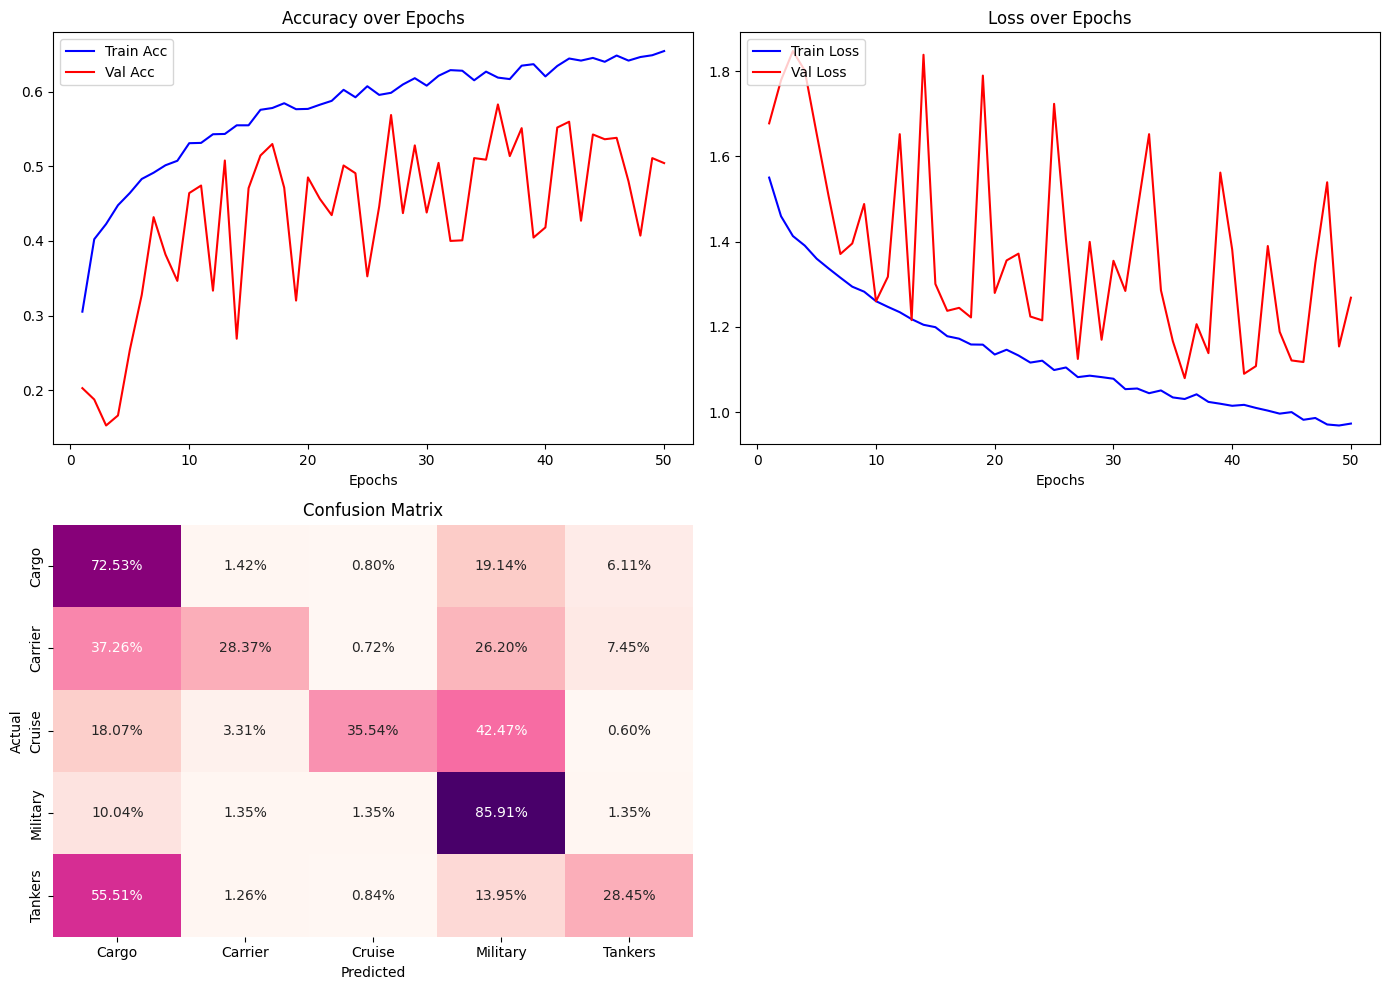

In [ ]:
x_val = np.arange(1, epochs + 1)

fig, axList = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
axList = axList.flatten()

axList[0].plot(x_val, history.history["acc"], color = "blue", label = "Train Acc")
axList[0].plot(x_val, history.history["val_acc"], color = "red", label = "Val Acc")
axList[0].set(title = "Accuracy over Epochs", xlabel = "Epochs")
axList[0].legend(loc = "upper left")

axList[1].plot(x_val, history.history["loss"], color = "blue", label = "Train Loss")
axList[1].plot(x_val, history.history["val_loss"], color = "red", label = "Val Loss")
axList[1].set(title = "Loss over Epochs", xlabel = "Epochs")
axList[1].legend(loc = "upper left")

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis = 1, keepdims = True)

sns.heatmap(cm, annot = True, fmt = ".2%", xticklabels = encoded_features, yticklabels = encoded_features, ax = axList[2], cmap = plt.cm.RdPu, cbar = False)
axList[2].set(title = "Confusion Matrix", xlabel = "Predicted", ylabel = "Actual")

axList[3].set_visible(False)

plt.tight_layout()
plt.show()

- The model has an approximate of 50% of identifying ships correctly. It seems to be suffering from overfitting, as it is unable to generalise the features.
- It is unable to identify Carriers, Cruise and Tankers well, and while it can identify Cargo and Military well, it is also having a high False Negative rate for both categories.

### <a id = "conclusion">Conclusion</a>

- We have created a Convolutional Neural Netowk model that can identify ship images and classify them.
- Unfortunately, based on physical limitations, we are unable to create a complex neural network or have more training data for the model to learn the important features. As a result, the model may not perform well.
- Also, the vast difference in images in the same category made it difficult for the model to learn well.
- However, coming from a physical hardware limitation perspective, having 3 hidden layers and training it with 2500 images with 224x224 pixels has been a challenge, and a 50% accuracy rate (from 20%) is a big jump.

#### Things to do in future (hopefully improve model)
- ImageDataGenerator does not have grayscale feature, can use tf.image.rgb_to_grayscale to convert RGB images to grayscale
- Increase training hyper-parameters or even neural network layers if you have a better physical hardware
- Increase number of original training images (e.g. oversampling or increase undersampling limit above 500)
- Conduct Cross Validation to ensure the full dataset is used for training and testing
- Try out CNN models using transfer learning